<center><h1><u>Abalone age prediction</u></h1></center>

<img src='static/abalone.jpg' style="width:250px; height:250px; float:right"/>

## Problem statement
Typically, the age of an abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope.This process is tedious and time-consuming.<br>
<b>Predict the age of abalone from physical measurements.</b>

## Machine Learning problem
- Type : Supervised Learning Regression problem
- Performance Metric : Root mean squared error

## Dataset information 
- 8 attributes
- 4177 instances

`Sex`: nominal - M (male), F (female), I (infant)

`Length`: continuous - longest shell measurement (in mm)

`Diameter`: continuous - measurement perpendicular to legnth (in mm)

`Height`: continuous - with meat in shell (in mm)

`Whole weight`: continuous - the whole abalone (in grams)

`Shucked weight`: continuous - weight of the meat (in grams)

`Viscera weight`: continuous - gut weight after bleeding (in grams)

`Shell weight`: continuous - after being dried (in grams)

`Rings`: integer - +1.5 gives the age in years

Dataset source : http://archive.ics.uci.edu/ml/datasets/Abalone

## 1. Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import (Lasso, Ridge, ElasticNet)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import pickle
import warnings

def evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test):
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    y_cv_preds = model.predict(X_cv)
    
    train_error = np.sqrt(mean_squared_error(y_train, y_train_preds))
    test_error =  np.sqrt(mean_squared_error(y_test, y_test_preds))
    cv_error =  np.sqrt(mean_squared_error(y_cv, y_cv_preds))
    return train_error, cv_error, test_error   

warnings.filterwarnings('ignore')
sns.set()

## 2. Loading dataset

In [2]:
data = pd.read_csv('data/abalone.data', header=None, index_col=False)

data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

data['age'] = data.rings + 1.5 #add target(age) to dataset [rings + 1.5 = age ]

data.drop('rings', axis=1, inplace=True) #remove rings variable
data.sample(5)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
1489,F,0.605,0.485,0.165,0.9515,0.4535,0.1930,0.2765,12.5
1895,M,0.570,0.455,0.155,0.8320,0.3585,0.1740,0.2770,12.5
2487,F,0.630,0.510,0.185,1.2350,0.5115,0.3490,0.3065,12.5
2652,I,0.515,0.400,0.125,0.5925,0.2650,0.1175,0.1680,10.5
930,I,0.440,0.325,0.090,0.3500,0.1480,0.0670,0.1050,8.5


In [3]:
X = data.drop('age', axis=1)
y = data.age

## 3. Exploratory data analysis

#### 3a. Missing values

In [4]:
missing_values = data.isnull().sum().sort_values(ascending = False)
percentage_missing_values = (missing_values/len(data))*100
pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', 'Missing %'])

,Missing values,Missing %
age,0,0.0
shell_weight,0,0.0
viscera_weight,0,0.0
shucked_weight,0,0.0
whole_weight,0,0.0
height,0,0.0
diameter,0,0.0
length,0,0.0
sex,0,0.0


Observation: There are no missing values in the dataset

#### 3b. Variable Identification

In [5]:
vid = ['categorical' if data[col].dtype == object else 'continuous' for col in data.columns]

temp = pd.DataFrame([data.columns, data.dtypes, vid]).T
temp.columns = ['variable', 'dtype', 'identity']

num_vars = X.select_dtypes(include=[np.number]).columns.values
cat_vars = X.select_dtypes(include=[object]).columns.values

temp

,variable,dtype,identity
0,sex,object,categorical
1,length,float64,continuous
2,diameter,float64,continuous
3,height,float64,continuous
4,whole_weight,float64,continuous
5,shucked_weight,float64,continuous
6,viscera_weight,float64,continuous
7,shell_weight,float64,continuous
8,age,float64,continuous


Observation: 

Continuous features (7):
length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight

Categorical features (1): 
sex

### 3c. Univariate Analysis

#### 3c.(i) Continuous variables

In [6]:
temp = pd.DataFrame([X[num_vars].mean(), 
                  X[num_vars].median(),
                  X[num_vars].mode().iloc[0],
                  X[num_vars].min(),
                  X[num_vars].max(),
                  X[num_vars].std(),
                  X[num_vars].skew(),
                  X[num_vars].kurtosis()
                 ]).T.reset_index()
temp.columns = ['variable','mean','median','mode', 'min', 'max', 'std', 'skewness', 'kurtosis']
temp

,variable,mean,median,mode,min,max,std,skewness,kurtosis
0,length,0.523992,0.5450,0.5500,0.0750,0.8150,0.120093,-0.639873,0.064621
1,diameter,0.407881,0.4250,0.4500,0.0550,0.6500,0.099240,-0.609198,-0.045476
2,height,0.139516,0.1400,0.1500,0.0000,1.1300,0.041827,3.128817,76.025509
3,whole_weight,0.828742,0.7995,0.2225,0.0020,2.8255,0.490389,0.530959,-0.023644
4,shucked_weight,0.359367,0.3360,0.1750,0.0010,1.4880,0.221963,0.719098,0.595124
5,viscera_weight,0.180594,0.1710,0.1715,0.0005,0.7600,0.109614,0.591852,0.084012
6,shell_weight,0.238831,0.2340,0.2750,0.0015,1.0050,0.139203,0.620927,0.531926


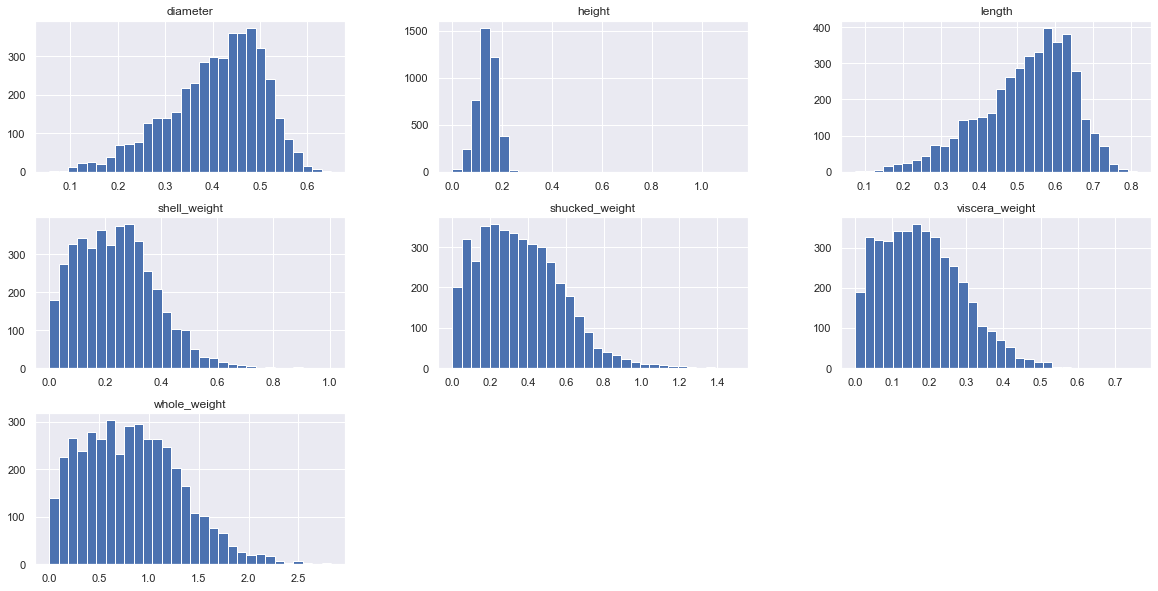

In [7]:
#Histogram
X[num_vars].hist(figsize=(20,10), bins=30)
plt.show()

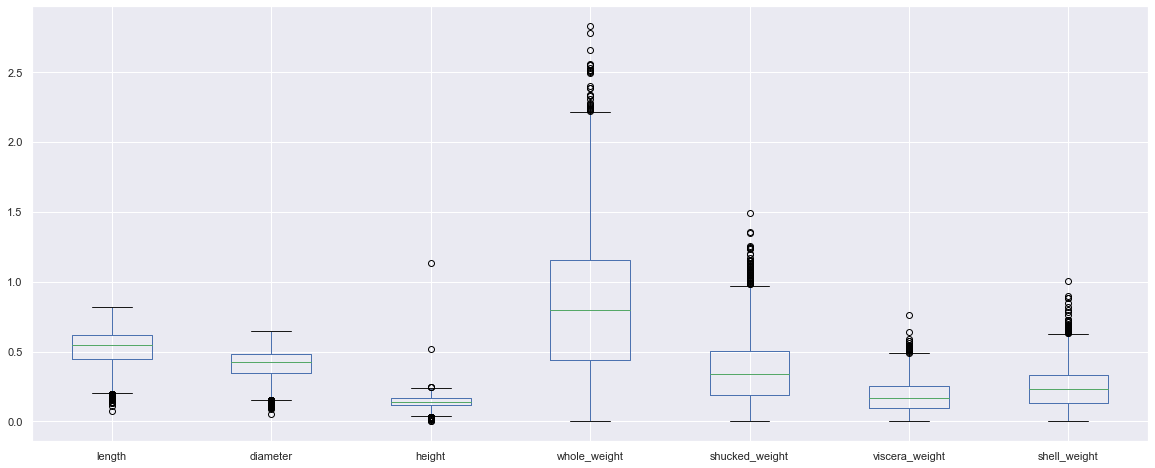

In [8]:
#Boxplot
X[num_vars].plot(kind='box',figsize=(20,8))
plt.show()

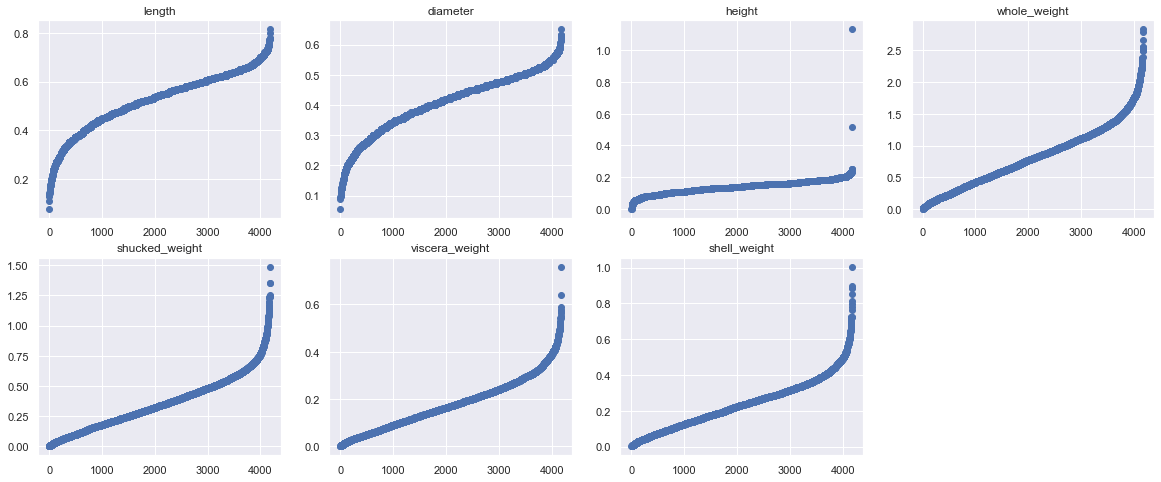

In [9]:
#Scatterplot
plt.figure(figsize=(20,8))
for i, col in enumerate(num_vars):
    plt.subplot(2,4,i+1)
    plt.scatter(range(len(X)), np.sort(X[num_vars[i]]))
    plt.title(num_vars[i])
plt.show()

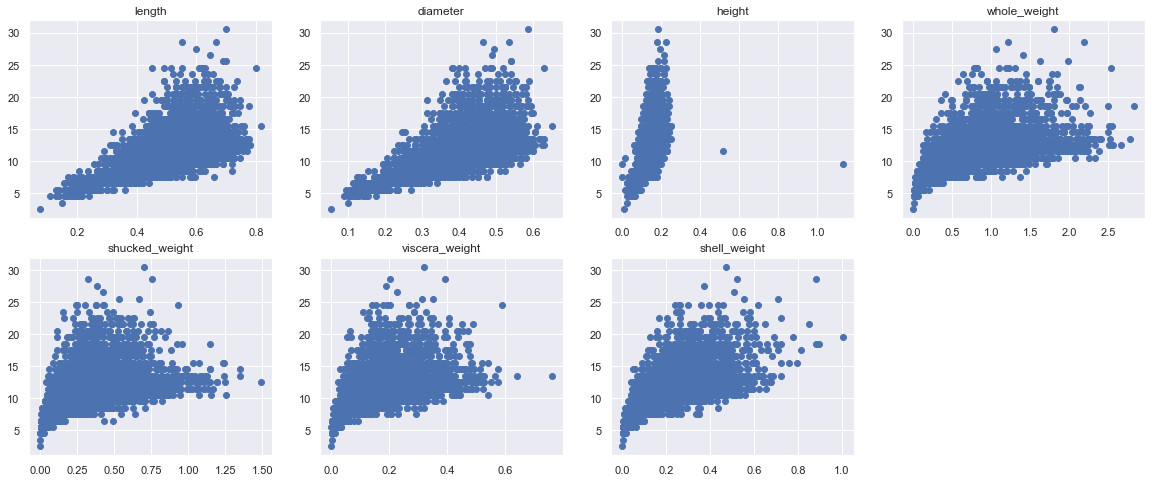

In [10]:
#Scatterplot - Relation btw variables and target

plt.figure(figsize=(20,8))
for i, col in enumerate(num_vars):
    plt.subplot(2,4,i+1)
    plt.scatter(X[num_vars[i]], y)
    plt.title(num_vars[i])
plt.show()

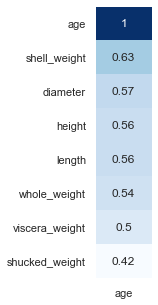

In [11]:
#Correlation btw variables and target
plt.figure(figsize=(1,5))
sns.heatmap(
    data.corr(method='pearson')[['age']].sort_values('age', ascending=False), 
    annot=True, cbar=False, cmap='Blues')
plt.show()

Obeservation :<br>
- Distribution of continuous variables<br>
- Outliers are present in some variables<br>
- height variable outliers should be removed<br>
- shell_weight is the most correlated variable with target

#### 3c.(ii) Categorical variables

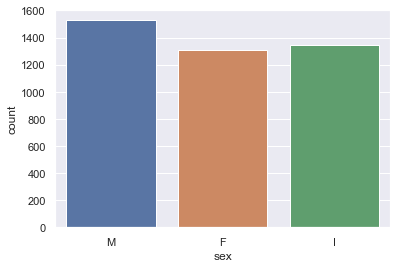

In [12]:
#Countplot
sns.countplot(x = X.sex)
plt.show()

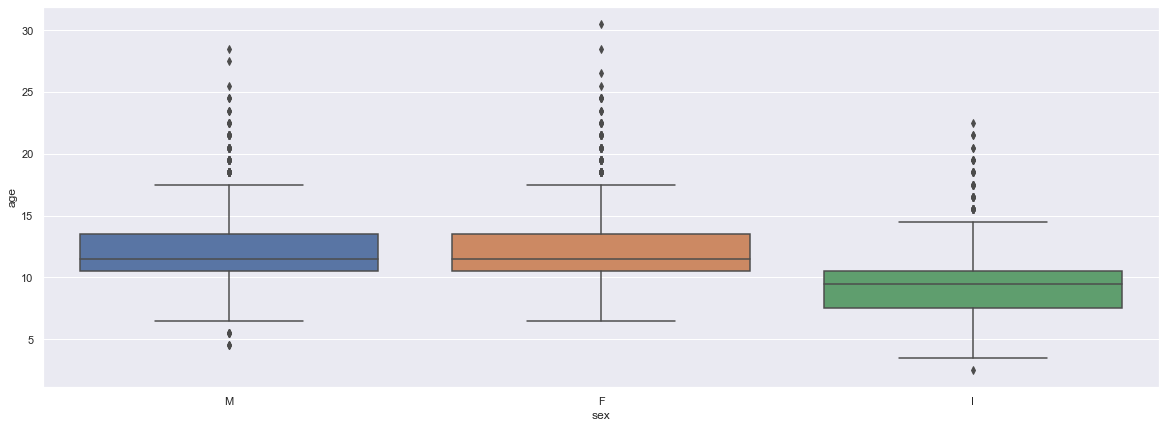

In [13]:
#BoxPlot
plt.figure(figsize=(20,7))
sns.boxplot(data = data, x='sex', y='age')
plt.show()

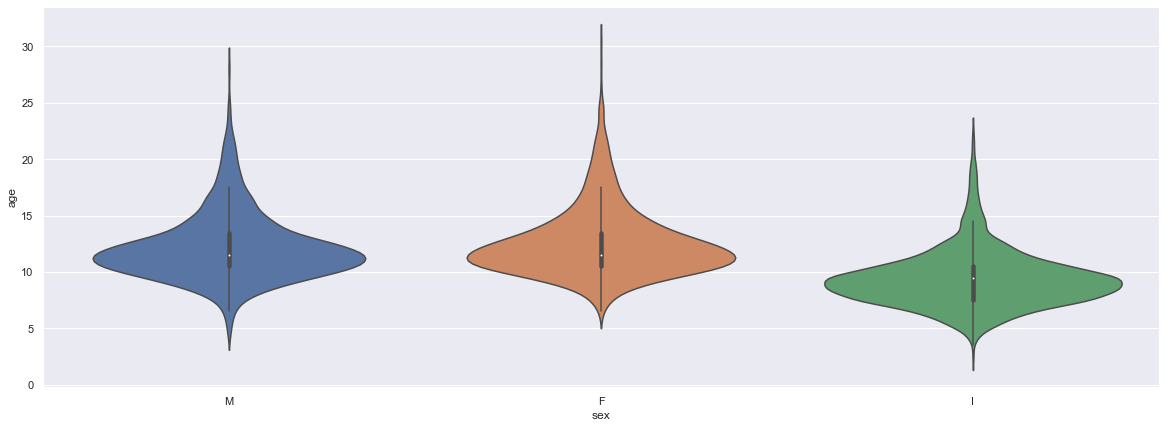

In [14]:
#BoxPlot
plt.figure(figsize=(20,7))
sns.violinplot(data = data, x='sex', y='age')
plt.show()

Observation:

 - Label I(infant) has relatively low maximum age(<25) which is obvious.<br>
 - The oldest abalone is a female

### 3d. Bivariate analysis

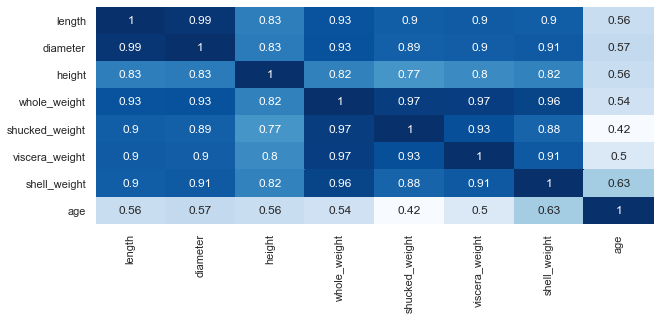

In [15]:
##Correlation with each other
plt.figure(figsize=(10,4)) #Correlation
sns.heatmap(data.corr(method='pearson'), annot=True, cbar=False, cmap='Blues')
plt.show()

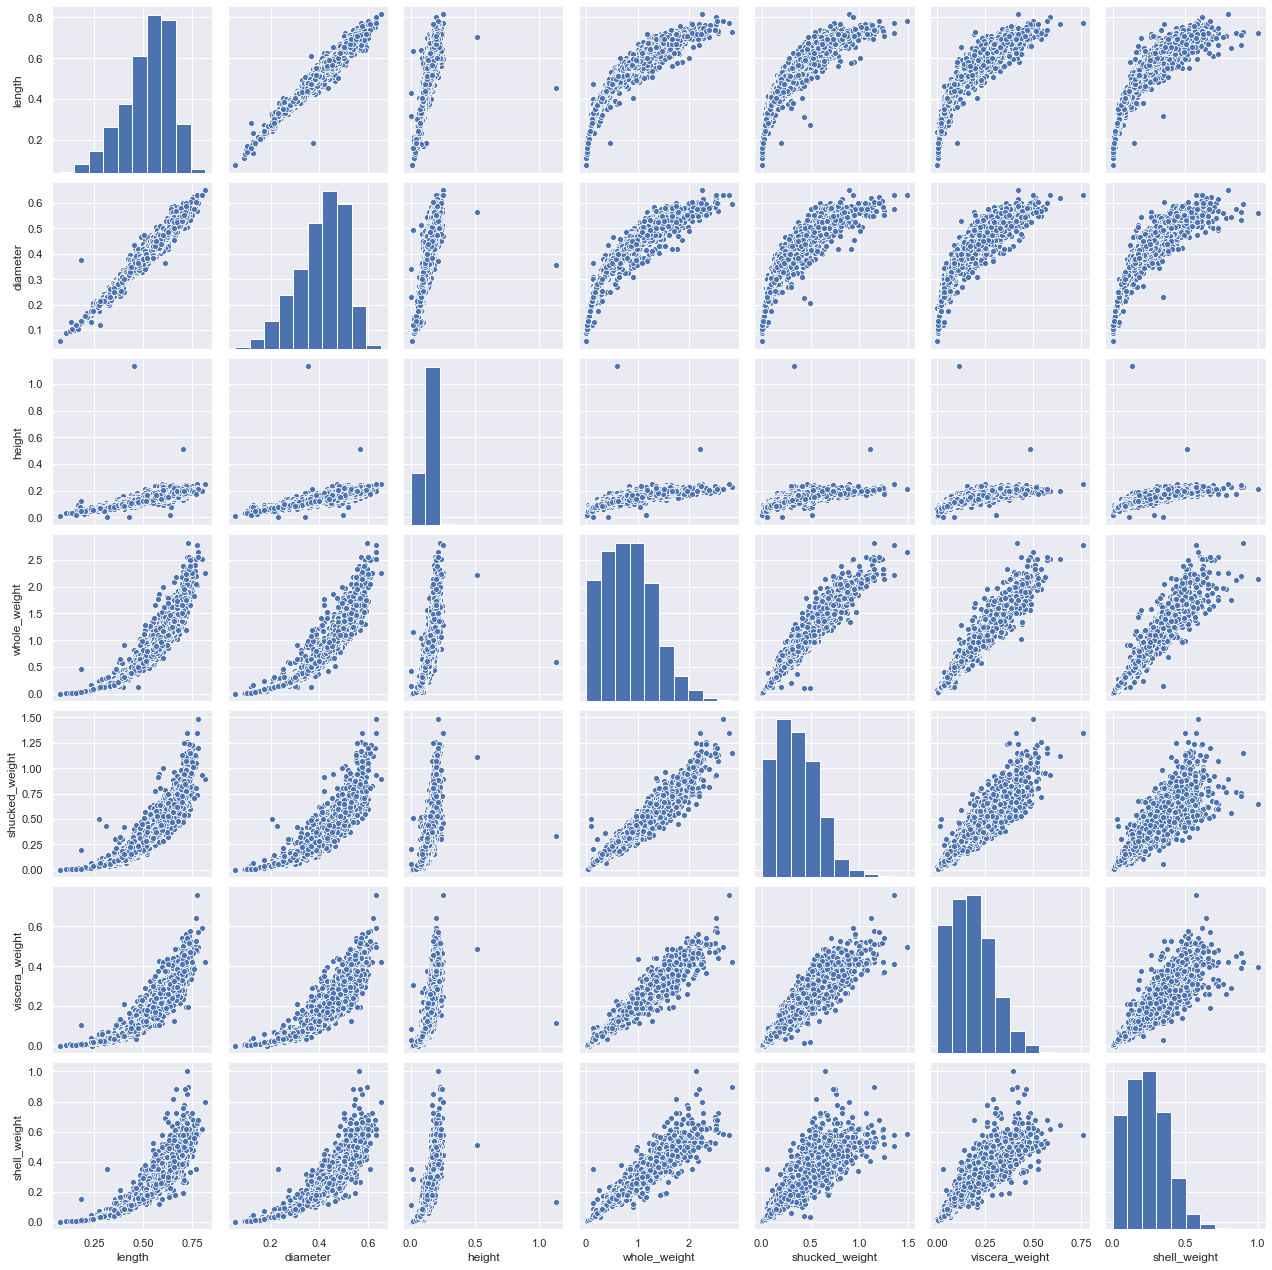

In [16]:
#PairPlot
sns.pairplot(X[num_vars])
plt.show()

Observation:

 - MultiCollinearity exists among variables<br>
 - (diameter, length)  highly correlated

# 4. Feature engineering

### 4a. Handling Outliers

 - Based on EDA removing outliers

In [17]:
outliers = X.loc[(X.height>0.4) | (X.shucked_weight>1.35) | (X.viscera_weight>0.6) | (X.shell_weight>1)]
X = X.drop(outliers.index)
y = y.drop(outliers.index)
print("No. of outliers removed : ", len(outliers))
outliers

No. of outliers removed :  7


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
163,F,0.725,0.560,0.210,2.1410,0.6500,0.3980,1.0050
1209,F,0.780,0.630,0.215,2.6570,1.4880,0.4985,0.5860
1417,M,0.705,0.565,0.515,2.2100,1.1075,0.4865,0.5120
1528,M,0.725,0.575,0.240,2.2100,1.3510,0.4130,0.5015
1762,M,0.770,0.620,0.195,2.5155,1.1155,0.6415,0.6420
1763,M,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780
2051,F,0.455,0.355,1.130,0.5940,0.3320,0.1160,0.1335


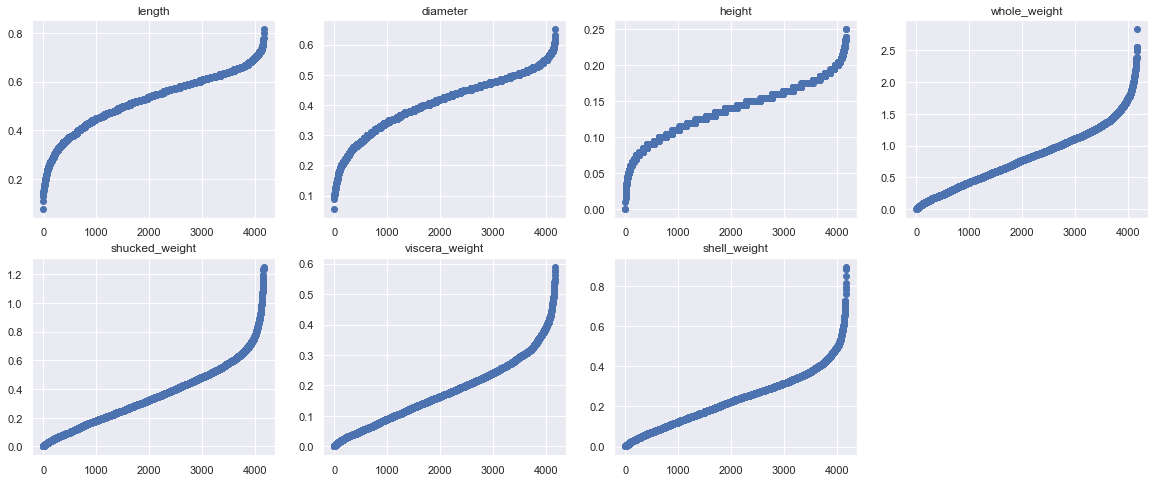

In [18]:
#Scatterplot 
plt.figure(figsize=(20,8))
for i, col in enumerate(num_vars):
    plt.subplot(2,4,i+1)
    plt.scatter(range(len(X)), np.sort(X[num_vars[i]]))
    plt.title(num_vars[i])
plt.show()

### 4b. Handling Categorical variable

- One hot encoding

In [19]:
X = pd.get_dummies(X, drop_first=True)
X.head(3)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,0,0


### // Data Splitting
- Train
- Cross-validation
- Test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print("No of data points in train set:",X_train.shape[0])
print("No of data points in cross-validation set:",X_cv.shape[0])
print("No of data points in test set:",X_test.shape[0])

No of data points in train set: 2668
No of data points in cross-validation set: 668
No of data points in test set: 834


# 5. Machine Learning
- Original data

### 5a. Random model 
- Returns mean age

In [21]:
print('train error:',np.sqrt(mean_squared_error(y_train,np.full(len(y_train), y_train.mean()))))
print('cv error:',np.sqrt(mean_squared_error(y_cv,np.full(len(y_cv), y_train.mean()))))
print('test error:',np.sqrt(mean_squared_error(y_test,np.full(len(y_test), y_train.mean()))))

train error: 3.1991768798564757
cv error: 3.197918002284404
test error: 3.3199839539626073


### 5b. Base model
- Linear regression

In [22]:
tr_err, cv_err, test_err = evaluate(LinearRegression(), X_train, X_cv, X_test, y_train, y_cv, y_test)

model = LinearRegression()

model.fit(X_train, y_train)
y_pr = model.predict(X_test)

print("train error",tr_err)
print("cv error", cv_err)
print("test error", test_err)

train error 2.170673260848304
cv error 2.183920424277641
test error 2.182882710330583


### 5.c Linear models

In [23]:
linear_models ={'linear_regression':LinearRegression(),
         'lasso':Lasso(),
         'ridge':Ridge(),
         'elastic_net':ElasticNet()
        }

In [24]:
df1 = []

for _, model in linear_models.items():
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df1.append([_, train_error, cv_error, test_error])

df1 = pd.DataFrame(df1, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('CV Error')
df1

,Model,Train Error,CV Error,Test Error
0,linear_regression,2.170673,2.183920,2.182883
2,ridge,2.187441,2.209865,2.204150
3,elastic_net,3.066367,3.066874,3.179551
1,lasso,3.199177,3.197918,3.319984


In [25]:
#Hyperparameter tuning
models_params ={'linear_regression':{'fit_intercept':[True,False]},
                
                'lasso':{'alpha': [1e-4, 1e-3, 1e-2, 1, 10, 100]},

                'ridge':{'alpha':[1e-4, 1e-3, 1e-2, 1, 10, 100]},

                'elastic_net':{"alpha": [1e-4, 1e-3, 1e-2, 1, 10, 100],
                               "l1_ratio": np.arange(0.0, 1.1, 0.2)},
               }


In [26]:
df2 = []
for model_name in linear_models.keys():
    print(model_name)
    model = linear_models[model_name]
    params = models_params[model_name]
    regressor = RandomizedSearchCV(estimator = model,
                                   n_iter=10,
                                   param_distributions = params,
                                   cv = 3,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs=-1)
    
    search = regressor.fit(X_train, y_train)
    model = search.best_estimator_
    
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df2.append(['best '+model_name, train_error, cv_error, test_error])
    print('Best params :',search.best_params_)
    print()
df2 = pd.DataFrame(df2, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('CV Error')    
df2

linear_regression
Best params : {'fit_intercept': True}

lasso
Best params : {'alpha': 0.0001}

ridge
Best params : {'alpha': 0.01}

elastic_net
Best params : {'l1_ratio': 0.6000000000000001, 'alpha': 0.0001}



,Model,Train Error,CV Error,Test Error
1,best lasso,2.170717,2.183671,2.183043
0,best linear_regression,2.170673,2.183920,2.182883
2,best ridge,2.170683,2.184109,2.182793
3,best elastic_net,2.171654,2.186611,2.183385


### 5d. Non-Linear models

In [27]:
non_linear_models ={'KNeighborsRegressor':KNeighborsRegressor(),
         'DecisionTreeRegressor':DecisionTreeRegressor(random_state=0),
         'SVR':SVR(kernel='rbf'),
         'RandomForestRegressor':RandomForestRegressor(random_state=0)
        }

In [28]:
df3 = []

for name, model in non_linear_models.items():
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df3.append([name, train_error, cv_error, test_error])

df3 = pd.DataFrame(df3, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('Test Error')
df3

,Model,Train Error,CV Error,Test Error
3,RandomForestRegressor,0.817245,2.210333,2.226302
0,KNeighborsRegressor,1.842986,2.278433,2.291073
2,SVR,2.269024,2.287480,2.314132
1,DecisionTreeRegressor,0.000000,3.000249,3.101017


In [29]:
#Hyperparameter tuning
models_params2 ={'KNeighborsRegressor':{'n_neighbors':[3,5,11,19],
                                        'metric':['euclidean', 'manhattan']
                                       },
                 
                
                'DecisionTreeRegressor':{"max_depth": [3,2, None],
                                         "max_features": np.random.randint(1, 9, 4),
                                         "min_samples_leaf": np.random.randint(1, 9,4),
                                        },
                 

                'SVR': {'kernel' : ('linear', 'poly', 'sigmoid'),
                        'C' : [0,1,5,10],
                       },
                 

                'RandomForestRegressor':{'max_depth': [3,5,None],
                                         'max_features': np.random.randint(1, 10,5),
                                         'min_samples_leaf': np.random.randint(1, 10,5),
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [10,20,30,40,50,100,200]
                                        }
                }

In [30]:
df4 = []
for model_name in non_linear_models.keys():
    print(model_name)
    model = non_linear_models[model_name]
    params = models_params2[model_name]
    regressor = RandomizedSearchCV(estimator = model,
                                   n_iter=10,
                                   param_distributions = params,
                                   cv = 3,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs=-1)
    
    search = regressor.fit(X_train, y_train)
    model = search.best_estimator_
    
    train_error, cv_error, test_error = evaluate(model, X_train, X_cv, X_test, y_train, y_cv, y_test)
    
    df4.append(['best '+model_name, train_error, cv_error, test_error])
    
    print('Best params :',search.best_params_)
    print()
df4 = pd.DataFrame(df4, columns=['Model', 'Train Error', 'CV Error', 'Test Error']).sort_values('CV Error')    
df4

KNeighborsRegressor
Best params : {'n_neighbors': 11, 'metric': 'euclidean'}

DecisionTreeRegressor
Best params : {'min_samples_leaf': 7, 'max_features': 5, 'max_depth': None}

SVR
Best params : {'kernel': 'poly', 'C': 10}

RandomForestRegressor
Best params : {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 5, 'max_depth': None}



,Model,Train Error,CV Error,Test Error
3,best RandomForestRegressor,1.692119,2.143665,2.153860
2,best SVR,2.185605,2.215523,2.253095
0,best KNeighborsRegressor,1.999700,2.242102,2.240345
1,best DecisionTreeRegressor,1.741346,2.596515,2.426021


In [31]:
df = pd.concat([df1,df2,df3,df4]).sort_values('CV Error')
df

,Model,Train Error,CV Error,Test Error
3,best RandomForestRegressor,1.692119,2.143665,2.153860
1,best lasso,2.170717,2.183671,2.183043
0,linear_regression,2.170673,2.183920,2.182883
0,best linear_regression,2.170673,2.183920,2.182883
2,best ridge,2.170683,2.184109,2.182793
3,best elastic_net,2.171654,2.186611,2.183385
2,ridge,2.187441,2.209865,2.204150
3,RandomForestRegressor,0.817245,2.210333,2.226302
2,best SVR,2.185605,2.215523,2.253095
0,best KNeighborsRegressor,1.999700,2.242102,2.240345


### 5d. Final model

- RandomForestRegressor

In [37]:
final_model = RandomForestRegressor(n_estimators= 200,
                                    min_samples_split= 5,
                                    min_samples_leaf= 7,
                                    max_features= 5, 
                                    max_depth= None,
                                    random_state=0
                                   )
final_model.fit(X_train, y_train)

RandomForestRegressor(max_features=5, min_samples_leaf=7, min_samples_split=5,
                      n_estimators=200, random_state=0)

In [38]:
train_preds = final_model.predict(X_train)
cv_preds = final_model.predict(X_cv)
test_preds = final_model.predict(X_test)

print('Train RMSE',np.sqrt(mean_squared_error(y_train, train_preds)))
print('CV RMSE',np.sqrt(mean_squared_error(y_cv, cv_preds)))
print('Test RMSE',np.sqrt(mean_squared_error(y_test, test_preds)))
print('\nTest predictions:',test_preds[:5])

Train RMSE 1.6921188889470864
CV RMSE 2.143665138689923
Test RMSE 2.1538596407005266

Test predictions: [11.68899598  9.05475643 15.10646118 11.6747081  10.07504398]


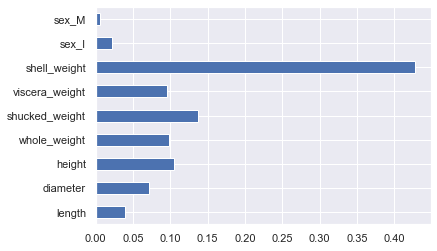

In [39]:
pd.Series(final_model.feature_importances_,index=X_train.columns).plot.barh()
plt.show()

# 6. Saving the final model

In [40]:
f = open('rf_model.pkl', 'wb')
pickle.dump(final_model, f)
f.close()

In [43]:
f = open('rf_model.pkl', 'rb')
model = pickle.load(f)
f.close()

preds = model.predict(X_test)
print('\nTest predictions:',np.round(preds[:5],1))


Test predictions: [11.7  9.1 15.1 11.7 10.1]


In [44]:
print('Test original:', y_test[:5].values)

Test original: [12.5  9.5 12.5 11.5  8.5]
